In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from IPython.display import SVG
from sknetwork.clustering import Louvain, get_modularity
from sklearn.preprocessing import normalize
from sknetwork.utils import get_membership
from sknetwork.visualization import svg_graph, svg_bigraph
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix, coo_matrix
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from wordcloud import WordCloud



from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import normalize
from sknetwork.clustering import Louvain, PropagationClustering, get_modularity
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
from transformers import AutoTokenizer, AutoModel, pipeline
import pandas as pd
from sklearn.preprocessing import normalize

# Load the dataset
test = pd.read_csv("data/test.csv")

# Initialize the tokenizer and model from the pre-trained 'philschmid/BERT-Banking77'
model_id = 'philschmid/BERT-Banking77'
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id)

def get_bert_embeddings(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()  
    normalized_embeddings = normalize(embeddings, axis=1, norm='l2')  # Normalize the embeddings
    return normalized_embeddings

# Apply the function to the 'text' column
test['embeddings'] = test['text'].apply(lambda x: get_bert_embeddings([x])[0])

# Show the DataFrame with embeddings
print(test[['text', 'embeddings']])

                                                   text  \
0                              How do I locate my card?   
1     I still have not received my new card, I order...   
2     I ordered a card but it has not arrived. Help ...   
3      Is there a way to know when my card will arrive?   
4                          My card has not arrived yet.   
...                                                 ...   
3075      If i'm not in the UK, can I still get a card?   
3076                 How many countries do you support?   
3077              What countries do you do business in?   
3078             What are the countries you operate in.   
3079         Can the card be mailed and used in Europe?   

                                             embeddings  
0     [0.025442058, -0.033863317, 0.002684306, 0.007...  
1     [0.0107224, 0.007851437, 0.07274575, -0.013251...  
2     [0.012323509, -0.010357802, 0.079115346, 0.011...  
3     [-0.002008599, -0.0009892696, 0.08350485, -0.0...  
4

Louvain

In [24]:
from sklearn.metrics import pairwise_distances
from sknetwork.clustering import Louvain, PropagationClustering
from sknetwork.linalg import normalize
import numpy as np
# Convert embeddings to a matrix
embedding_matrix = np.vstack(test['embeddings'])

similarity_matrix = np.dot(embedding_matrix, embedding_matrix.T)

similarity_matrix[similarity_matrix < 0.3] = 0

adjacency = csr_matrix(similarity_matrix)

In [30]:
# Loop over a range of resolution parameters to find the one that maximizes the silhouette score
best_resolution = 1.0
best_modularity = float('-inf')
best_labels = None

for resolution in np.linspace(0.5, 2, 10):

    louvain = Louvain(resolution=resolution)
    labels = louvain.fit_predict(adjacency)
    modularity = get_modularity(adjacency, labels)
    
    if modularity > best_modularity:
        best_modularity = modularity
        best_resolution = resolution
        best_labels = labels

print("Best resolution parameter:", best_resolution)
print("Best modularity:", best_modularity)

Best resolution parameter: 1.0
Best modularity: 0.8148158291188176


In [31]:
# Apply the Louvain method
louvain = Louvain(resolution=1)
labels = louvain.fit_predict(adjacency)

In [32]:
labels_unique, counts = np.unique(labels, return_counts=True)
print(labels_unique, counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [369 242 227 204 201 163 163 159 155 125 121 121 121 120 119 116  82  74
  43  40  40  38  37]


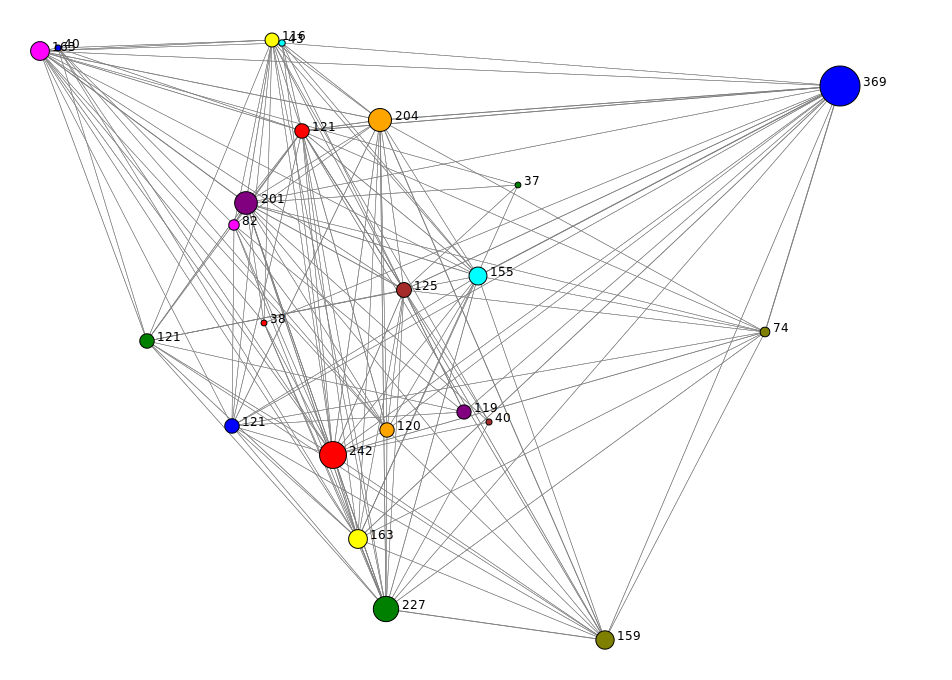

In [35]:
svd = TruncatedSVD(n_components=2)
position = svd.fit_transform(embedding_matrix)

adjacency_aggregate = louvain.aggregate_
average = normalize(get_membership(labels).T)

position_aggregate = average.dot(position)
labels_unique, counts = np.unique(labels, return_counts=True)
image = svg_graph(adjacency_aggregate, position_aggregate, counts, labels=labels_unique,
                    display_node_weight=True, node_weights=counts, scale = 2)
SVG(image)

In [36]:
# Calculate modularity
get_modularity(adjacency, labels)

0.8148158291188176

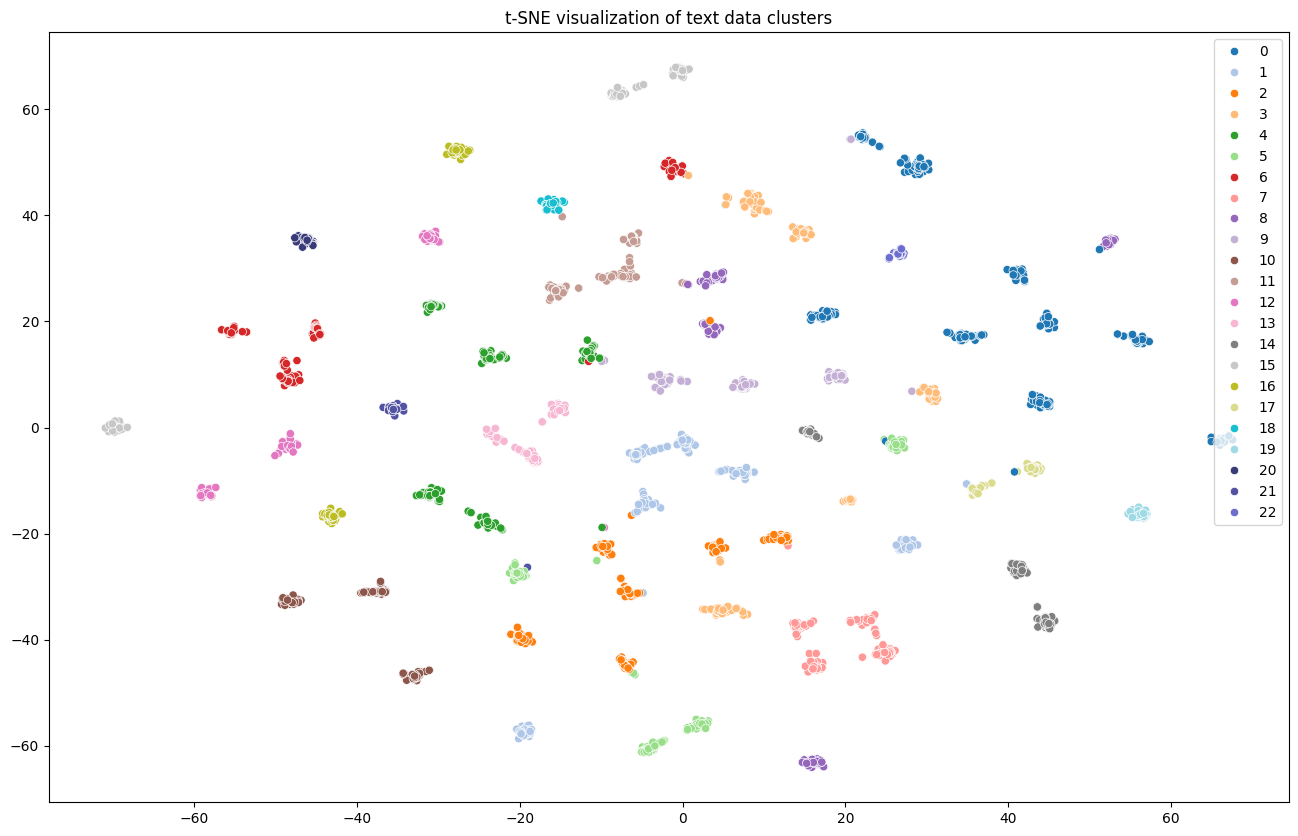

In [47]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(embedding_matrix)

# Combine 'tab20' and 'tab20b' colormaps to get 40 distinct colors
tab20_colors = plt.cm.tab20(np.linspace(0, 1, 20))
tab20b_colors = plt.cm.tab20b(np.linspace(0, 1, 20))
combined_colors = np.vstack((tab20_colors, tab20b_colors))

# Select the first 23 colors for your palette
palette = combined_colors[:num_clusters]

plt.figure(figsize=(16, 10))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=labels, 
                palette=sns.color_palette(palette, num_clusters), legend="full")
plt.title('t-SNE visualization of text data clusters')
plt.show()


The average silhouette_score is : 0.22387318


/tmp/ipykernel_63668/2522409156.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_silhouette_values, bins=20, kde=True)


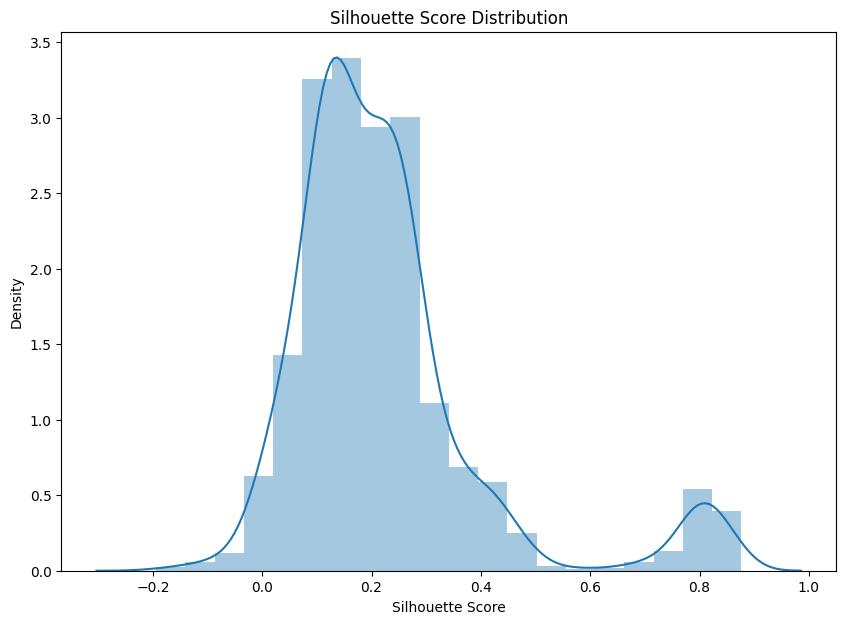

In [45]:
silhouette_avg = silhouette_score(embedding_matrix, labels)
print("The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding_matrix, labels)

plt.figure(figsize=(10, 7))
sns.distplot(sample_silhouette_values, bins=20, kde=True)
plt.title('Silhouette Score Distribution')
plt.xlabel('Silhouette Score')
plt.ylabel('Density')
plt.show()


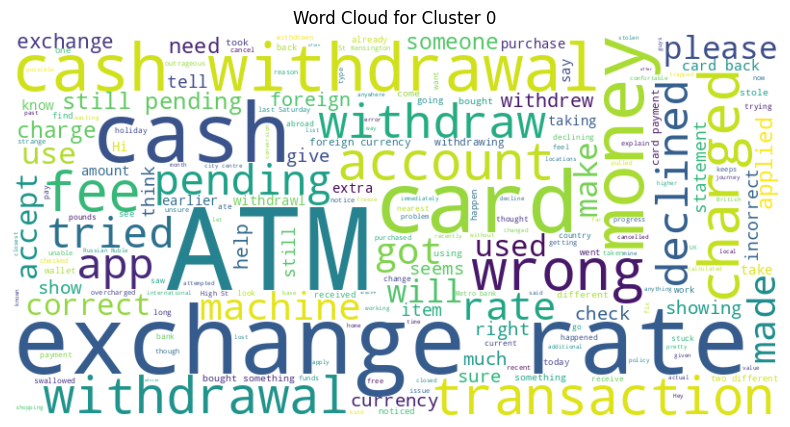

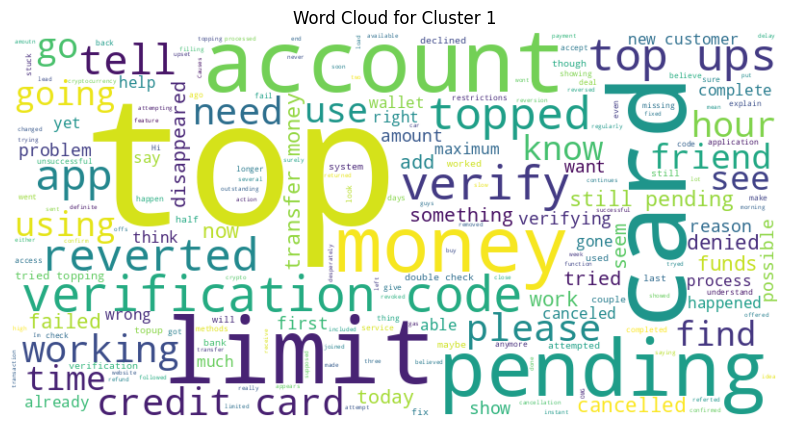

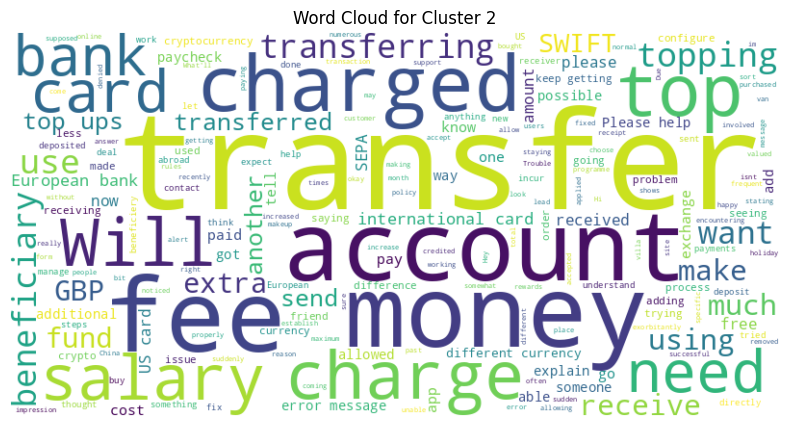

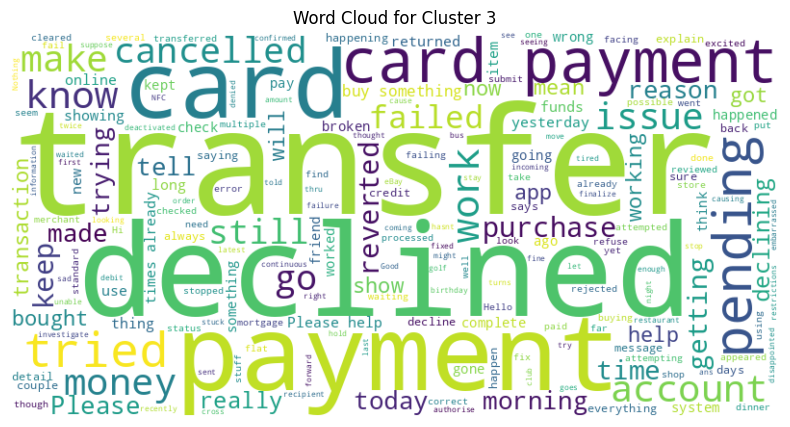

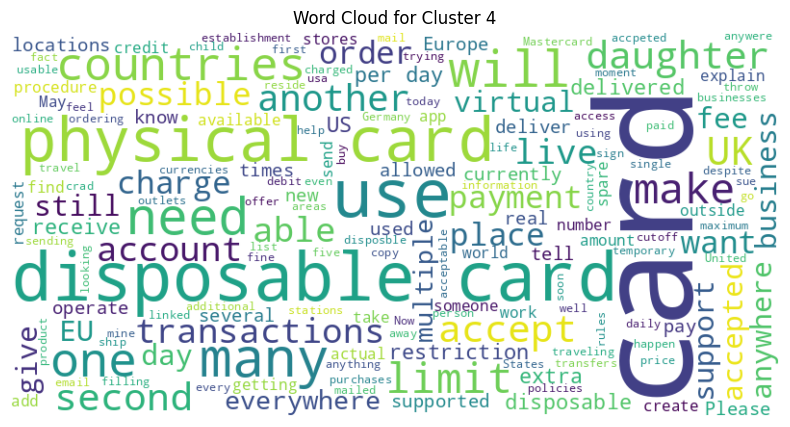

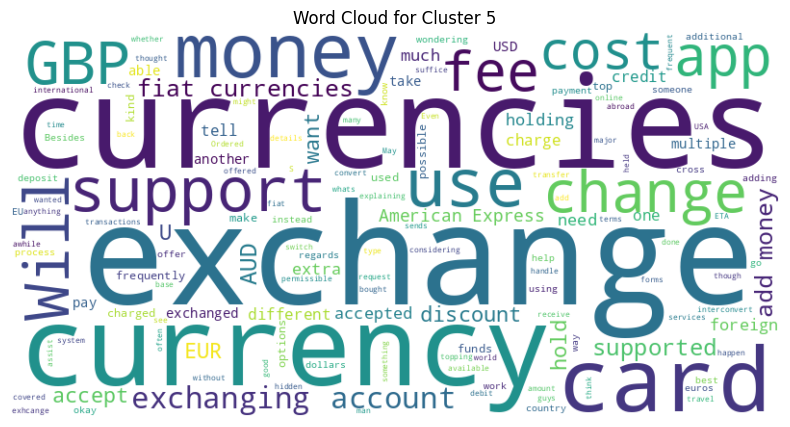

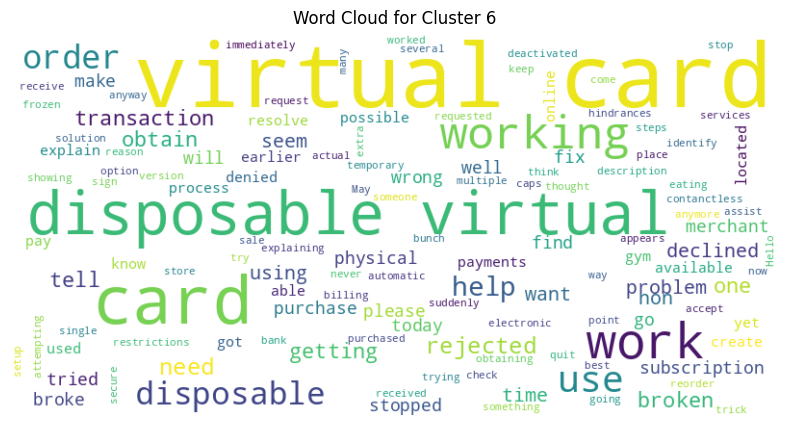

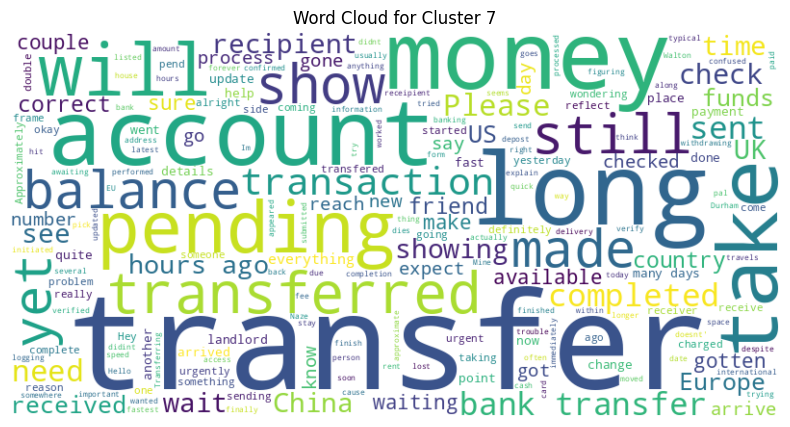

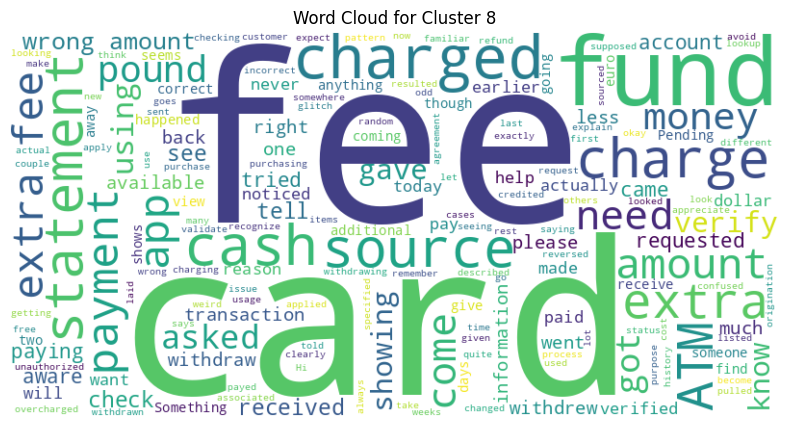

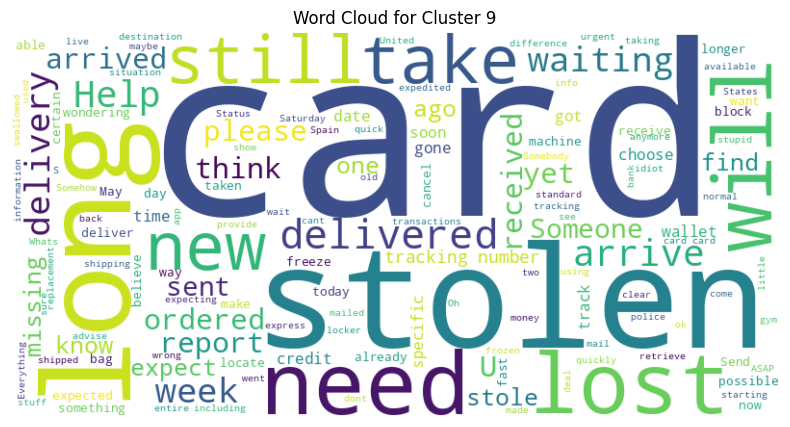

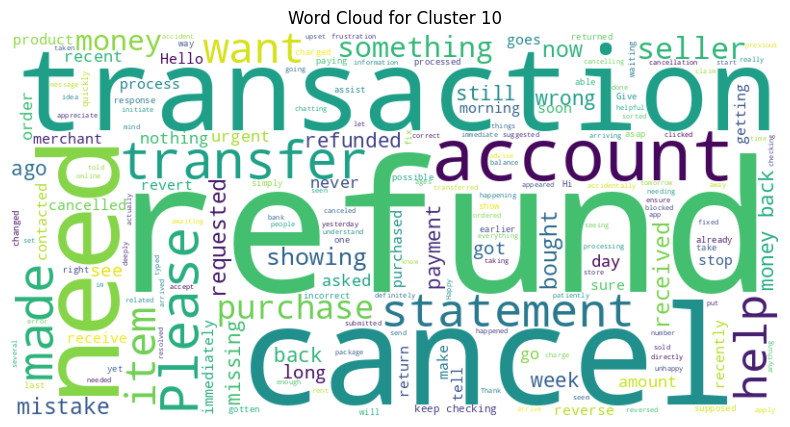

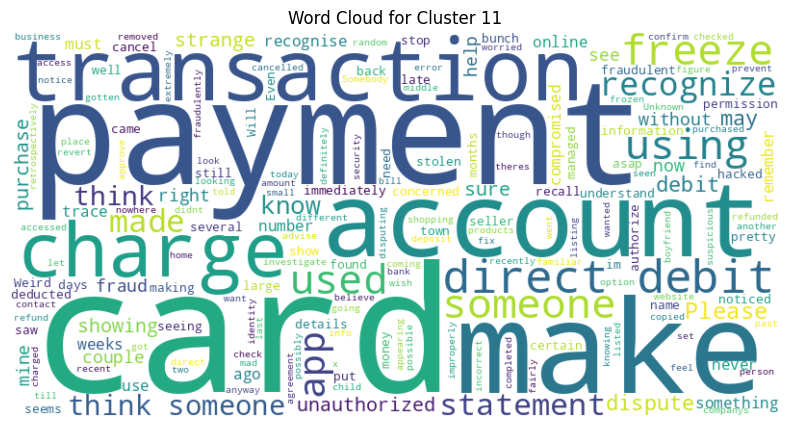

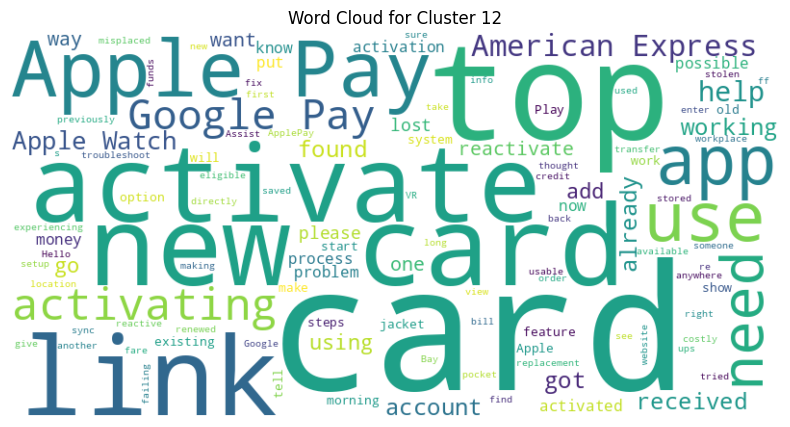

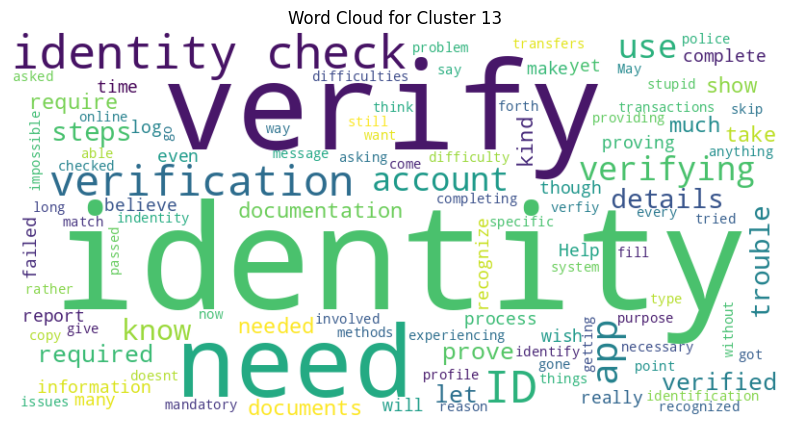

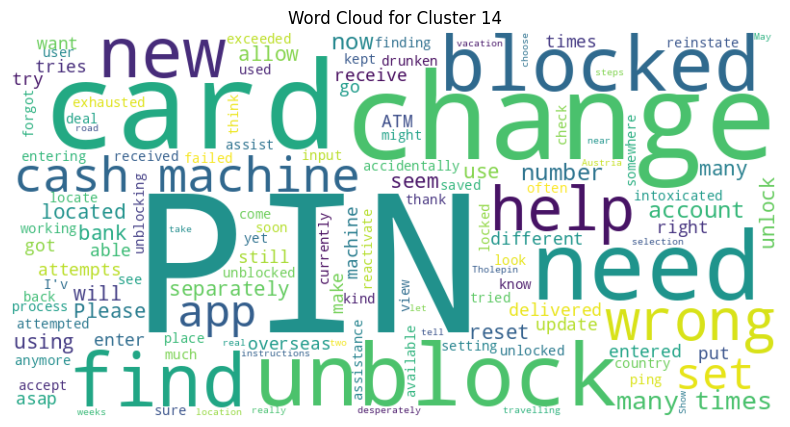

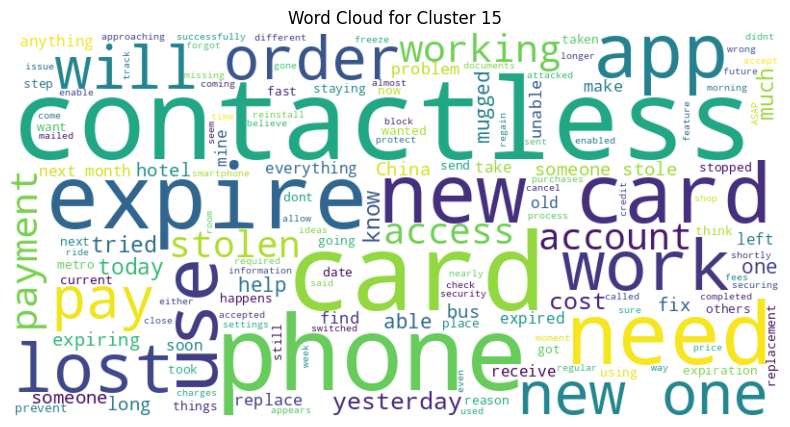

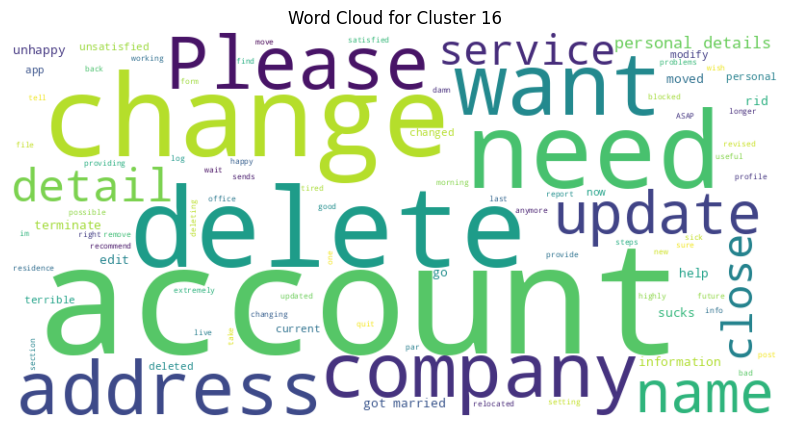

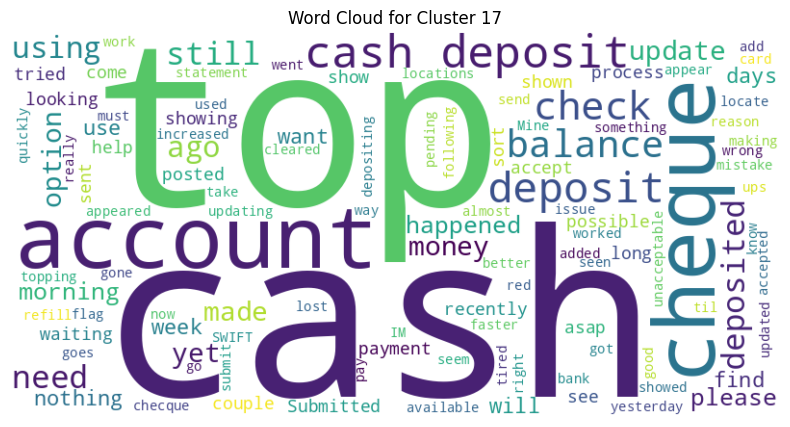

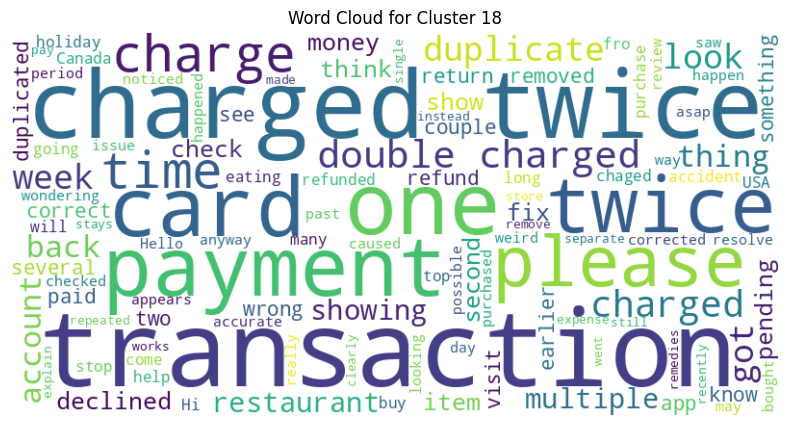

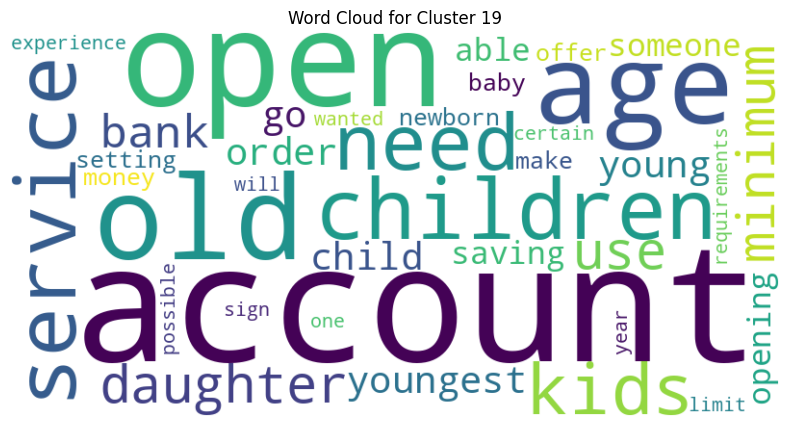

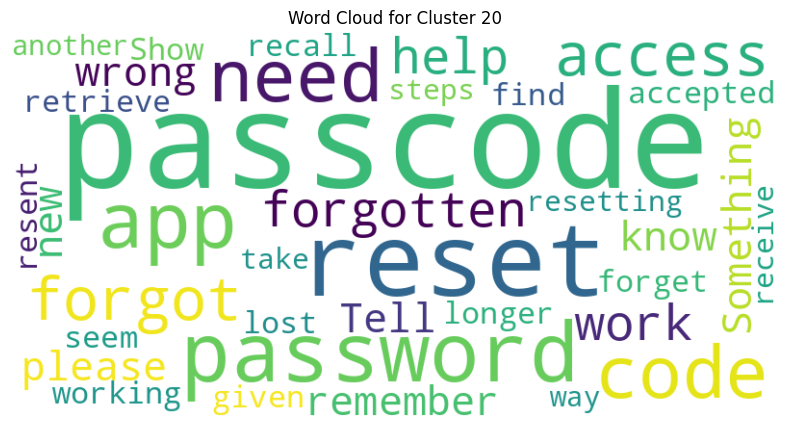

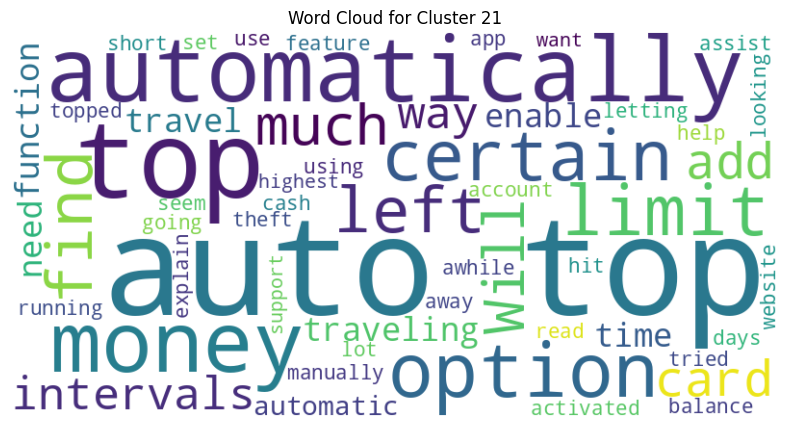

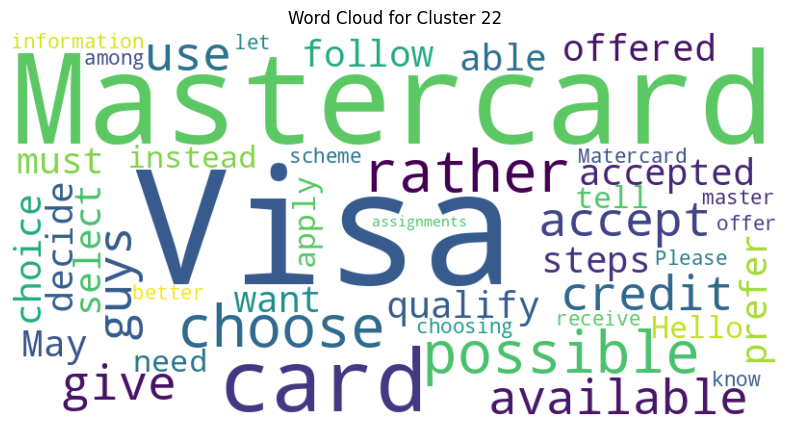

In [ ]:
def generate_word_clouds(data, labels, num_clusters):
    for i in range(num_clusters):
        # Filter the data for the current cluster
        cluster_texts = data[data['cluster'] == i]['text']

        # Join all texts in the cluster into a single string
        cluster_text = ' '.join(cluster_texts)

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)

        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Cluster {i}')
        plt.show()

# Add the cluster labels to the DataFrame
test['cluster'] = labels

# Determine the number of clusters
num_clusters = len(set(labels))

# Generate word clouds for each cluster
generate_word_clouds(test, labels, num_clusters)


In [48]:
for i in range(num_clusters):
    print(f'Cluster {i}:')
    cluster_texts = test[test['cluster'] == i]['text'].tolist()
    for text in cluster_texts[:10]:  # Print the first 10 texts in each cluster
        print(text)
    print('\n')


Cluster 0:
I need to know your exchange rates.
What exchange rates do you offer?
How did you come up with your exchange rates?
Where do you guys acquire your exchange rate?
How do I find the exchange rate?
What are your international exchange rates?
How often do your exchange rates change
Please advise what is the exchange rate
How are exchange rates calculated?
what are exchange rates based on


Cluster 1:
Is there a top-up feature, if there isn't a lot of money left?
new customer and filling gas today, it's not working, the thing shows pending half an hour!
My card was topped this morning but I can't see the funds. Why didn't it complete?
What would lead to my top up still pending?
there's a delay in my top-up
Is there a reason my top up hasn't gone through
The top-up is pending.
Could you explain why my top-up has gone through yet?
I've already topped up, but I cannot see the funds being available. What happened?
What is going on? My top-up is still pending. I use your system all th

In [52]:
from collections import Counter
from nltk.corpus import stopwords

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

for i in range(num_clusters):
    cluster_texts = test[test['cluster'] == i]['text']
    # Split the texts into words and filter out stopwords
    words = [word for text in cluster_texts for word in text.split() if word.lower() not in stop_words]
    word_counts = Counter(words)
    print(f'Most common words in Cluster {i}:')
    print(word_counts.most_common(10))  # Print the 10 most common words
    print('\n')


Most common words in Cluster 0:
[('exchange', 97), ('cash', 94), ('ATM', 73), ('rate', 72), ('withdrawal', 51), ('card', 48), ('get', 38), ('money', 38), ('charged', 33), ('wrong', 28)]


Most common words in Cluster 1:
[('top', 99), ('top-up', 75), ('card', 25), ('money', 23), ('up?', 18), ('verification', 18), ('limit', 16), ('card?', 15), ('verify', 15), ('topped', 14)]


Most common words in Cluster 2:
[('transfer', 76), ('money', 37), ('charged', 28), ('fee', 27), ('top', 26), ('account', 24), ('bank', 20), ('account?', 20), ('fees', 18), ('transfer?', 17)]


Most common words in Cluster 3:
[('payment', 77), ('card', 76), ('transfer', 61), ('tried', 23), ('declined.', 18), ('declined', 16), ('declined?', 16), ('know', 15), ('pending', 14), ('make', 13)]


Most common words in Cluster 4:
[('card', 65), ('card?', 55), ('get', 42), ('disposable', 33), ('cards', 29), ('use', 25), ('physical', 23), ('many', 18), ('countries', 13), ('one', 13)]


Most common words in Cluster 5:
[('excha

In [55]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

for i in range(num_clusters):
    cluster_texts = test[test['cluster'] == i]['text']
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(cluster_texts)
    lda = LatentDirichletAllocation(n_components=3, random_state=0)
    lda.fit(X)
    print(f'Topics in Cluster {i}:')
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx+1}: {' '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-5:]])}")
    print('\n')


Topics in Cluster 0:
Topic 1: pending cash withdrawal rate exchange
Topic 2: rate wrong fee charged cash
Topic 3: cash account money card atm


Topics in Cluster 1:
Topic 1: tell account ups limit pending
Topic 2: using transfer credit money card
Topic 3: verify card reverted code verification


Topics in Cluster 2:
Topic 1: swift transfers beneficiary fees transfer
Topic 2: using bank use salary card
Topic 3: charged fee account money transfer


Topics in Cluster 3:
Topic 1: payment work did declined transfer
Topic 2: money payment failed cancelled transfer
Topic 3: tried pending declined payment card


Topics in Cluster 4:
Topic 1: able live uk use card
Topic 2: card make physical disposable cards
Topic 3: account daughter second countries card


Topics in Cluster 5:
Topic 1: accept exchanges fiat card currencies
Topic 2: does cost money exchange currency
Topic 3: use gbp cards exchange currencies


Topics in Cluster 6:
Topic 1: use working disposable virtual card
Topic 2: cards work